In [1]:
# Copyright (c) Nanjing University, Vision Lab.
# Last update: 2019.10.27
# 2019.11.14

# Evaluate R-D performance

In [2]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pylab  as plt
import pandas as pd
import subprocess
import configparser
from numba import cuda
tf.enable_eager_execution()

/home/ubuntu/anaconda3/envs/py3-mink/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/py3-mink/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/py3-mink/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/py3-mink/lib

In [3]:
from mycodec_hyper import preprocess, postprocess, compress, decompress, \
write_binary_files, read_binary_files

# if necessary, maybe you should consider compression with less memory, which eocode each block respectively.
from mycodec_hyper import preprocess, postprocess, compress_less_mem, decompress_less_mem, \
write_binary_files_less_mem, read_binary_files_less_mem

In [4]:
import models.model_voxception as model

### set GPU/CPU

In [5]:
os.environ['CUDA_VISIBLE_DEVICES']="0"

# set gpu.
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1.0
config.gpu_options.allow_growth = True
config.log_device_placement=True
# config.device_count={'gpu':0}
sess = tf.Session(config=config)

### Metrics

In [6]:
from myutils.pc_error_wrapper import pc_error
from myutils.pc_error_wrapper import get_points_number

## Set config

In [7]:
input_file = '/home/ubuntu/Desktop/wjq/AVS/learned-point-cloud-geometry-compression/testdata/MVUB/david_vox9_frame0000.ply'
# input_file = '/home/ubuntu/HardDisk1/shapenet256/10.ply'
# input_file = '/home/ubuntu/Desktop/wjq/learnedpcc/testdata/basketball_player_vox11_00000200.ply'
# input_file = '/home/ubuntu/Desktop/wjq/learnedpcc/testdata/dancer_vox11_00000001.ply'
filename = os.path.split(input_file)[-1][:-4]
output_file = filename + '_rec.ply'
# input_file_n = input_file[:-4]+'_n.ply'
input_file_n = input_file

config_file = os.path.join('./config/hyper/', filename+'.ini')
config = configparser.ConfigParser()
if os.path.exists(config_file):
    config.read(config_file)
    print('config already exists.')
else:
    config["DEFAULT"] = {"cube_size": 64, 
                        "min_num": 10,
                        "resolution":512}

    config["R1"] = {"scale": 5/8.,
                   "ckpt_dir": './checkpoints/hyper/a0.75b3/'}

    config["R2"] = {"scale": 1.0,
                   "ckpt_dir": './checkpoints/hyper/a0.75b3/'}

    config["R3"] = {"scale": 1.0,
                   "ckpt_dir": './checkpoints/hyper/a2b3/'}

    config["R4"] = {"scale": 1.0,
                   "ckpt_dir": './checkpoints/hyper/a3.5b3/'}

    config["R5"] = {"scale": 1.0,
                   "ckpt_dir": './checkpoints/hyper/a6b3/'}
    
    config["R6"] = {"scale": 1.0,
                   "ckpt_dir": './checkpoints/hyper/a10b3/'}

    config["R7"] = {"scale": 1.0,
                   "ckpt_dir": './checkpoints/hyper/a16b3/'}
    config.write(open(config_file, 'w'))
    
    print('initialize config.')
    

initialize config.


### Select rho

In [8]:
def select_rho(item, input_file, output_file, input_file_n, 
               cubes_d, points_numbers_d, cube_positions_d, scale, cube_size, res):

    steps = [0.02]*4+[0.04]*4+[0.08]*4+[0.16]*4+[0.32]*4
    MAX = 0
    rho = 1.0
    optimal_rho = 1.0

    for i, step in enumerate(steps):
        print('===== select rho =====')
        postprocess(output_file, cubes_d, points_numbers_d, cube_positions_d, scale, cube_size, rho)
        results = pc_error(input_file, output_file, input_file_n, res, show=False)
        """
        # record results.
        results["n_points"] = get_points_number(output_file)
        results["rho"] = rho
        if i == 0:
            all_results = results.copy(deep=True)
        else:
            all_results = all_results.append(results, ignore_index=True)
        """

        PSNR = float(results[item])
        print('===== results: ', i, rho, item, PSNR)

        MAX = max(PSNR, MAX)
        if PSNR < MAX:
            break
        else:
            optimal_rho = rho

        if item == "mseF,PSNR (p2point)":
            rho += step
        elif item == "mseF,PSNR (p2plane)":
            rho -= step
        else:
            print('ERROR', item)
            break
    
    return optimal_rho

## Run

In [9]:
for index, rate in enumerate(config.sections()):
    print(rate)

R1
R2
R3
R4
R5
R6
R7


In [10]:
# model = 'model_voxception'
cube_size = config.getint('DEFAULT', 'cube_size')
min_num = config.getint('DEFAULT', 'min_num')
res = config.getint('DEFAULT', 'resolution')

print('cube size:', cube_size, 'min num:', min_num, 'res:', res)

for index, rate in enumerate(config.sections()):
    scale = float(config.get(rate, 'scale'))
    ckpt_dir = str(config.get(rate, 'ckpt_dir'))
    print('====================', 'config:', rate, 'scale:', scale, 'ckpt_dir:', ckpt_dir)

    # Pre-process
    cubes, cube_positions, points_numbers = preprocess(input_file, scale, cube_size, min_num)
    ### Encoding
    y_strings, y_min_vs, y_max_vs, y_shape, z_strings, z_min_v, z_max_v, z_shape, x_ds = \
    compress_less_mem(cubes, model, ckpt_dir, True)
    # Write files
    filename = os.path.split(input_file)[-1][:-4]
    print(filename)
    rootdir = './compressed/'
    bytes_strings, bytes_strings_head, bytes_strings_hyper, bytes_pointnums, bytes_cubepos = \
    write_binary_files_less_mem(
    filename, y_strings.numpy(), z_strings.numpy(), points_numbers, cube_positions,
    y_min_vs.numpy(), y_max_vs.numpy(), y_shape.numpy(), 
    z_min_v.numpy(), z_max_v.numpy(), z_shape.numpy(), rootdir)
    # Read files
    y_strings_d, z_strings_d, points_numbers_d, cube_positions_d, \
    y_min_vs_d, y_max_vs_d, y_shape_d, z_min_v_d, z_max_v_d, z_shape_d = \
    read_binary_files_less_mem(filename, rootdir)
    # Decoding
    cubes_d = decompress_less_mem(y_strings_d, y_min_vs_d.astype('int32'), y_max_vs_d.astype('int32'), 
                                  y_shape_d, z_strings_d, z_min_v_d, z_max_v_d, z_shape_d, model, ckpt_dir)
    # cheat!!!
    ##############
    cubes_d = x_ds
    ##############
    # bpp
    N = get_points_number(input_file)
    bpp = round(8*(bytes_strings + 
                   bytes_strings_head + 
                   bytes_strings_hyper + 
                   bytes_pointnums + 
                   bytes_cubepos)/float(N), 4)
    
    bpp_strings = round(8*bytes_strings/float(N), 4)
    bpp_strings_head = round(8*bytes_strings_head/float(N), 4)
    bpp_strings_hyper = round(8*bytes_strings_hyper/float(N), 4)
    bpp_pointsnums = round(8*bytes_pointnums/float(N) ,4)
    bpp_cubepos = round(8*bytes_cubepos/float(N), 4)
    
    ########## Post-process ##########
    # select rho for optimal d1/d2 metrics.
    if config.has_option(rate, 'rho_d1'):
        rho_d1 = float(config.get(rate, 'rho_d1'))
    else:
        rho_d1 = select_rho("mseF,PSNR (p2point)", input_file, output_file, input_file_n, 
                        cubes_d, points_numbers_d, cube_positions_d, scale, cube_size, res)
        config.set(rate, 'rho_d1', str(rho_d1)) 
        config.write(open(config_file, 'w'))

    if config.has_option(rate, 'rho_d2'):
        rho_d2 = float(config.get(rate, 'rho_d2'))
    else:
        rho_d2 = select_rho("mseF,PSNR (p2plane)", input_file, output_file, input_file_n, 
                        cubes_d, points_numbers_d, cube_positions_d, scale, cube_size, res)
        config.set(rate, 'rho_d2', str(rho_d2))
        config.write(open(config_file, 'w'))
    
    # metrics.
    for index_rho, rho in enumerate((1.0, rho_d1, rho_d2)):
        postprocess(output_file, cubes_d, points_numbers_d, cube_positions_d, scale, cube_size, rho)

        # distortion
        results = pc_error(input_file, output_file, input_file_n, res, show=False)
        
        # bpp
        results["n_points"] = get_points_number(output_file)
        results["rho"] = rho
        results["ori_points"] = N
        results["scale"] = scale
        results["bpp_strings"] = bpp_strings
        results["bpp_strings_head"] = bpp_strings_head
        results["bpp_strings_hyper"] = bpp_strings_hyper
        results["bpp_pointsnums"] = bpp_pointsnums
        results["bpp_cubepos"] = bpp_cubepos
        results["bpp"] = bpp
        
        print(results)
        
        if index_rho == 0:
            if index == 0:
                all_results = results.copy(deep=True)
            else:
                all_results = all_results.append(results, ignore_index=True)
        elif index_rho == 1:
            if index == 0:
                all_results_d1 = results.copy(deep=True)
            else:
                all_results_d1 = all_results_d1.append(results, ignore_index=True)
        else:
            if index == 0:
                all_results_d2 = results.copy(deep=True)
            else:
                all_results_d2 = all_results_d2.append(results, ignore_index=True)    

# write to csv
print(all_results)
print(all_results_d1)
print(all_results_d2)
csv_root_dir = './CSV/hyper/'
if not os.path.exists(csv_root_dir):
    os.makedirs(csv_root_dir)

csv_name = os.path.join(csv_root_dir, filename + '.csv')
all_results.to_csv(csv_name, index=False)

csv_name_d1 = os.path.join(csv_root_dir, filename + '_d1.csv')
all_results_d1.to_csv(csv_name_d1, index=False)

csv_name_d2 = os.path.join(csv_root_dir, filename + '_d2.csv')
all_results_d2.to_csv(csv_name_d2, index=False)

cube size: 64 min num: 10 res: 512
==================== config: R1 scale: 0.625 ckpt_dir: ./checkpoints/hyper/a0.75b3/
===== Preprocess =====
Scaling: 1.0816s
Partition: 1.3616s
Voxelization: 0.0233s
cubes shape: (37, 64, 64, 64, 1)
points numbers (sum/mean/max/min): 127419 3444.0 10766 15
===== Compress =====
Instructions for updating:
Colocations handled automatically by placer.
Analysis Transform: 2.049s
Hyper Encoder: 0.0555s
Quantize hyperprior.
Hyper Decoder: 0.0803s
Entropy Encode (Hyper): 0.0049s
Entropy Encode: 0.2274s
Entropy Decode: 0.2207s
Synthesis Transform: 1.4678s
david_vox9_frame0000
===== Write binary files =====
Total file size (Bytes): 1897
Strings (Bytes): 1046
Strings head (Bytes): 76
Strings hyper (Bytes): 652
Numbers of points (Bytes): 74
Positions of cubes (Bytes): 49
===== Read binary files =====
===== Decompress =====
Entropy Decoder (Hyper): 0.02s
Hyper Decoder: 0.0734s
Entropy Decoder: 0.2212s
Synthesis Transform: 1.3728s
===== select rho =====
===== Post p

Synthesis Transform: 3.0785s
david_vox9_frame0000
===== Write binary files =====
Total file size (Bytes): 4543
Strings (Bytes): 2536
Strings head (Bytes): 178
Strings hyper (Bytes): 1582
Numbers of points (Bytes): 176
Positions of cubes (Bytes): 71
===== Read binary files =====
===== Decompress =====
Entropy Decoder (Hyper): 0.0217s
Hyper Decoder: 0.1502s
Entropy Decoder: 0.5397s
Synthesis Transform: 3.0799s
===== select rho =====
===== Post process =====
Classify and extract points: 0.2081s
Write point cloud to david_vox9_frame0000_rec.ply: 1.1229s
===== measure PCC quality using `pc_error` version 0.13.4 8.3176
===== results:  0 1.0 mseF,PSNR (p2point) 61.0646
===== select rho =====
===== Post process =====
Classify and extract points: 0.218s
Write point cloud to david_vox9_frame0000_rec.ply: 1.1376s
===== measure PCC quality using `pc_error` version 0.13.4 8.4652
===== results:  1 1.02 mseF,PSNR (p2point) 60.9994
===== select rho =====
===== Post process =====
Classify and extract p

Classify and extract points: 0.2178s
Write point cloud to david_vox9_frame0000_rec.ply: 1.0525s
===== measure PCC quality using `pc_error` version 0.13.4 7.8884
===== results:  3 0.94 mseF,PSNR (p2plane) 67.045
===== select rho =====
===== Post process =====
Classify and extract points: 0.213s
Write point cloud to david_vox9_frame0000_rec.ply: 1.0247s
===== measure PCC quality using `pc_error` version 0.13.4 7.8051
===== results:  4 0.9199999999999999 mseF,PSNR (p2plane) 67.1133
===== select rho =====
===== Post process =====
Classify and extract points: 0.2233s
Write point cloud to david_vox9_frame0000_rec.ply: 0.9744s
===== measure PCC quality using `pc_error` version 0.13.4 7.8928
===== results:  5 0.8799999999999999 mseF,PSNR (p2plane) 66.9869
===== Post process =====
Classify and extract points: 0.2141s
Write point cloud to david_vox9_frame0000_rec.ply: 1.1134s
===== measure PCC quality using `pc_error` version 0.13.4 8.2524
   mse1      (p2point)  mse1,PSNR (p2point)  mse1      (

===== measure PCC quality using `pc_error` version 0.13.4 7.8714
   mse1      (p2point)  mse1,PSNR (p2point)  mse1      (p2plane)  \
0             0.294295              64.2518             0.106974   

   mse1,PSNR (p2plane)  h.       1(p2point)  h.,PSNR  1(p2point)  \
0              68.6468                963.0              29.1034   

   h.       1(p2plane)  h.,PSNR  1(p2plane)  mse2      (p2point)  \
0              5.28115              51.7123             0.231592   

   mse2,PSNR (p2point)  ...  n_points   rho  ori_points  scale  bpp_strings  \
0              65.2924  ...    310797  0.94      330797    1.0       0.1738   

   bpp_strings_head  bpp_strings_hyper  bpp_pointsnums  bpp_cubepos     bpp  
0            0.0043             0.0536          0.0043       0.0017  0.2376  

[1 rows x 34 columns]
==================== config: R5 scale: 1.0 ckpt_dir: ./checkpoints/hyper/a6b3/
===== Preprocess =====
Scaling: 0.0s
Partition: 3.7521s
Voxelization: 0.0573s
cubes shape: (88, 64, 64, 64,

Classify and extract points: 0.213s
Write point cloud to david_vox9_frame0000_rec.ply: 1.1001s
===== measure PCC quality using `pc_error` version 0.13.4 7.8894
===== results:  2 0.96 mseF,PSNR (p2plane) 70.1159
===== select rho =====
===== Post process =====
Classify and extract points: 0.2161s
Write point cloud to david_vox9_frame0000_rec.ply: 1.0777s
===== measure PCC quality using `pc_error` version 0.13.4 8.0138
===== results:  3 0.94 mseF,PSNR (p2plane) 69.9516
===== Post process =====
Classify and extract points: 0.2138s
Write point cloud to david_vox9_frame0000_rec.ply: 1.1225s
===== measure PCC quality using `pc_error` version 0.13.4 8.2723
   mse1      (p2point)  mse1,PSNR (p2point)  mse1      (p2plane)  \
0             0.183853              66.2949              0.06397   

   mse1,PSNR (p2plane)  h.       1(p2point)  h.,PSNR  1(p2point)  \
0              70.8799                948.0              29.1715   

   h.       1(p2plane)  h.,PSNR  1(p2plane)  mse2      (p2point)  \
0

In [11]:
# csv_root_dir = './CSV/hyper/'
# if not os.path.exists(csv_root_dir):
#     os.makedirs(csv_root_dir)

# csv_name = os.path.join(csv_root_dir, filename + '.csv')
# if not os.path.exists(csv_name):
#     all_results.to_csv(csv_name, index=False)
# else:
#     collection = pd.read_csv(csv_name)
#     collection = collection.append(all_results, ignore_index=True)
#     collection.to_csv(csv_name, index=False)    

# csv_name_d1 = os.path.join(csv_root_dir, filename + '_d1.csv')
# if not os.path.exists(csv_name_d1):
#     all_results_d1.to_csv(csv_name_d1, index=False)
# else:
#     collection_d1 = pd.read_csv(csv_name_d1)
#     collection_d1 = collection_d1.append(all_results_d1, ignore_index=True)
#     collection_d1.to_csv(csv_name_d1, index=False)  

# csv_name_d2 = os.path.join(csv_root_dir, filename + '_d2.csv')
# if not os.path.exists(csv_name_d2):
#     all_results_d2.to_csv(csv_name_d2, index=False)
# else:
#     collection_d2 = pd.read_csv(csv_name_d2)
#     collection_d2 = collection_d2.append(all_results_d2, ignore_index=True)
#     collection_d2.to_csv(csv_name_d2, index=False)  

In [12]:
all_results

,mse1 (p2point),"mse1,PSNR (p2point)",mse1 (p2plane),"mse1,PSNR (p2plane)",h. 1(p2point),"h.,PSNR 1(p2point)",h. 1(p2plane),"h.,PSNR 1(p2plane)",mse2 (p2point),"mse2,PSNR (p2point)",...,n_points,rho,ori_points,scale,bpp_strings,bpp_strings_head,bpp_strings_hyper,bpp_pointsnums,bpp_cubepos,bpp
0,1.486070,64.6561,0.435106,69.9906,158.0,44.3899,102.9490,46.2503,1.094730,65.9835,...,384836,1.0,1000993,0.625,0.0229,0.0013,0.0134,0.0013,0.0006,0.0396
1,0.402164,70.3325,0.144569,74.7758,65.0,48.2474,24.1527,52.5469,0.345140,70.9966,...,1000607,1.0,1000993,1.000,0.0556,0.0031,0.0325,0.0030,0.0008,0.0950
2,0.195669,73.4613,0.087052,76.9787,162.0,44.2814,42.2224,50.1211,0.215487,73.0423,...,1000607,1.0,1000993,1.000,0.1034,0.0031,0.0407,0.0030,0.0008,0.1509
3,0.149990,74.6159,0.065019,78.2462,36.0,50.8135,22.8274,52.7920,0.154228,74.4949,...,1000607,1.0,1000993,1.000,0.1417,0.0031,0.0475,0.0030,0.0008,0.1961
4,0.114558,75.7863,0.046328,79.7181,26.0,52.2268,22.8274,52.7920,0.116139,75.7268,...,1000607,1.0,1000993,1.000,0.1864,0.0032,0.0621,0.0030,0.0008,0.2555
5,0.089887,76.8396,0.033768,81.0915,27.0,52.0629,20.5782,53.2425,0.091634,76.7559,...,1000607,1.0,1000993,1.000,0.2313,0.0034,0.0778,0.0030,0.0008,0.3163
6,0.077841,77.4645,0.027699,81.9519,29.0,51.7525,20.5782,53.2425,0.077076,77.5073,...,1000607,1.0,1000993,1.000,0.2936,0.0038,0.1016,0.0030,0.0008,0.4029


In [13]:
all_results_d1

,mse1 (p2point),"mse1,PSNR (p2point)",mse1 (p2plane),"mse1,PSNR (p2plane)",h. 1(p2point),"h.,PSNR 1(p2point)",h. 1(p2plane),"h.,PSNR 1(p2plane)",mse2 (p2point),"mse2,PSNR (p2point)",...,n_points,rho,ori_points,scale,bpp_strings,bpp_strings_head,bpp_strings_hyper,bpp_pointsnums,bpp_cubepos,bpp
0,1.202840,65.5745,0.375274,70.6330,126.96,45.3398,102.9720,46.2493,1.244030,65.4282,...,446378,1.16,1000993,0.625,0.0229,0.0013,0.0134,0.0013,0.0006,0.0396
1,0.366603,70.7346,0.133617,75.1179,65.00,48.2474,24.6786,52.4533,0.363162,70.7755,...,1040549,1.04,1000993,1.000,0.0556,0.0031,0.0325,0.0030,0.0008,0.0950
2,0.195669,73.4613,0.087052,76.9787,162.00,44.2814,42.2224,50.1211,0.215487,73.0423,...,1000607,1.00,1000993,1.000,0.1034,0.0031,0.0407,0.0030,0.0008,0.1509
3,0.149990,74.6159,0.065019,78.2462,36.00,50.8135,22.8274,52.7920,0.154228,74.4949,...,1000607,1.00,1000993,1.000,0.1417,0.0031,0.0475,0.0030,0.0008,0.1961
4,0.114558,75.7863,0.046328,79.7181,26.00,52.2268,22.8274,52.7920,0.116139,75.7268,...,1000607,1.00,1000993,1.000,0.1864,0.0032,0.0621,0.0030,0.0008,0.2555
5,0.089887,76.8396,0.033768,81.0915,27.00,52.0629,20.5782,53.2425,0.091634,76.7559,...,1000607,1.00,1000993,1.000,0.2313,0.0034,0.0778,0.0030,0.0008,0.3163
6,0.077841,77.4645,0.027699,81.9519,29.00,51.7525,20.5782,53.2425,0.077076,77.5073,...,1000607,1.00,1000993,1.000,0.2936,0.0038,0.1016,0.0030,0.0008,0.4029


In [14]:
all_results_d2

,mse1 (p2point),"mse1,PSNR (p2point)",mse1 (p2plane),"mse1,PSNR (p2plane)",h. 1(p2point),"h.,PSNR 1(p2point)",h. 1(p2plane),"h.,PSNR 1(p2plane)",mse2 (p2point),"mse2,PSNR (p2point)",...,n_points,rho,ori_points,scale,bpp_strings,bpp_strings_head,bpp_strings_hyper,bpp_pointsnums,bpp_cubepos,bpp
0,2.258110,62.8391,0.563874,68.8647,223.88,42.8764,103.5210,46.2262,0.907885,66.7962,...,292417,0.76,1000993,0.625,0.0229,0.0013,0.0134,0.0013,0.0006,0.0396
1,0.488815,69.4851,0.167086,74.1471,73.00,47.7433,24.1563,52.5462,0.309898,71.4643,...,920451,0.92,1000993,1.000,0.0556,0.0031,0.0325,0.0030,0.0008,0.0950
2,0.220653,72.9394,0.097250,76.4977,162.00,44.2814,42.2224,50.1211,0.198376,73.4016,...,960478,0.96,1000993,1.000,0.1034,0.0031,0.0407,0.0030,0.0008,0.1509
3,0.161307,74.3000,0.069622,77.9491,36.00,50.8135,22.8274,52.7920,0.145877,74.7367,...,980493,0.98,1000993,1.000,0.1417,0.0031,0.0475,0.0030,0.0008,0.1961
4,0.125981,75.3735,0.051059,79.2958,26.00,52.2268,22.8274,52.7920,0.108298,76.0303,...,980493,0.98,1000993,1.000,0.1864,0.0032,0.0621,0.0030,0.0008,0.2555
5,0.101643,76.3057,0.038308,80.5436,27.00,52.0629,22.8274,52.7920,0.083823,77.1429,...,980493,0.98,1000993,1.000,0.2313,0.0034,0.0778,0.0030,0.0008,0.3163
6,0.077841,77.4645,0.027699,81.9519,29.00,51.7525,20.5782,53.2425,0.077076,77.5073,...,1000607,1.00,1000993,1.000,0.2936,0.0038,0.1016,0.0030,0.0008,0.4029


### Plot performance

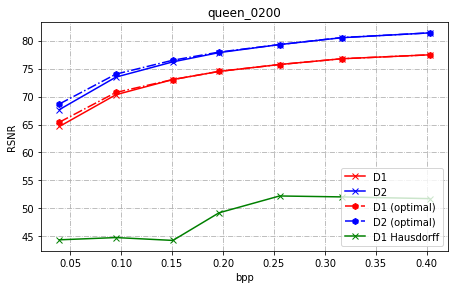

In [15]:
fig, ax = plt.subplots(figsize=(7.3, 4.2))

plt.plot(np.array(all_results["bpp"][:]), np.array(all_results["mseF,PSNR (p2point)"][:]), 
        label="D1", marker='x', color='red')
plt.plot(np.array(all_results["bpp"][:]), np.array(all_results["mseF,PSNR (p2plane)"][:]), 
        label="D2", marker='x', color = 'blue')

plt.plot(np.array(all_results_d1["bpp"][:]), np.array(all_results_d1["mseF,PSNR (p2point)"][:]), 
        label="D1 (optimal)", marker='h', color='red', linestyle='-.')
plt.plot(np.array(all_results_d2["bpp"][:]), np.array(all_results_d2["mseF,PSNR (p2plane)"][:]), 
        label="D2 (optimal)", marker='h', color='blue', linestyle='-.')

plt.plot(np.array(all_results["bpp"][:]), np.array(all_results["h.,PSNR   (p2point)"][:]), 
        label="D1 Hausdorff", marker='x', color = 'green')

plt.title(filename)
plt.xlabel('bpp')
plt.ylabel('RSNR')
plt.grid(ls='-.')
plt.legend(loc='lower right')

fig.savefig(os.path.join(csv_root_dir, filename+'.png'))